# Capacity Constraint Vehicel Routing Problem (CVRP)

In [2]:
import random as rd
import numpy as np
import pandas as pd
import math

import time
import datetime

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
NUM_NODES = 25

MAX_X = 1000
MAX_Y = 1000

NUM_VEHICLES = 4
MAX_CAPACITY = 50
NUM_DEPOT = 0

In [13]:
# 建立資料集
def create_data_model():

    data = {}
    data["num_locations"] = [(rd.randint(1, MAX_X), rd.randint(1, MAX_Y)) for i in range(NUM_NODES)] # 亂數產生 node 座標
    data["num_locations"][0] = (int(MAX_X / 2), int(MAX_Y / 2)) # 假設車輛皆從第中心點 index=0 的 node 出發
    data["distance_matrix"] = compute_manhattan_distance_matrix(data["num_locations"])
    data["demands"] = [rd.randint(1,10) for i in range(NUM_NODES)] # 每個地點都有一個需求，對應到要取貨的商品的數量 (例如重量或體積)。
    data["num_vehicles"] = NUM_VEHICLES
    data["vehicle_capacities"] = [MAX_CAPACITY for i in range(NUM_VEHICLES)] # 每輛車都有「容量」：車輛可以可容納的最大容量。當車輛沿著路線行駛時，其所載物品的總數量絕不會超過其容量。
    data["depot"] = NUM_DEPOT
    return data

def compute_manhattan_distance_matrix(nodes):
    distance_matrix = []
    for node_i in nodes:
        distances = []
        for node_j in nodes:
            if node_i == node_j:
                distances.append(0)
            else:
                manhattan_distance = np.sum(np.abs(np.array(node_i) - np.array(node_j)))
                distances.append(manhattan_distance)
        distance_matrix.append(distances)
    return distance_matrix

def create_result_model():
    result = {}
    result["routes"] = []
    return result

data = create_data_model()
result = create_result_model()

print('Locations:', data["num_locations"])

Locations: [(500, 500), (302, 378), (341, 620), (126, 624), (316, 809), (664, 5), (232, 77), (785, 879), (699, 707), (955, 69), (887, 11), (286, 467), (216, 765), (114, 195), (881, 604), (996, 87), (167, 477), (822, 243), (698, 751), (504, 809), (683, 77), (209, 392), (708, 272), (779, 690), (156, 935)]


In [14]:
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")
    total_distance = 0
    total_load = 0
    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        plan_output = f"Route for vehicle {vehicle_id}:\n"
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data["demands"][node_index]
            plan_output += f" {node_index} Load({route_load}) -> "
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id
            )
        plan_output += f" {manager.IndexToNode(index)} Load({route_load})\n"
        plan_output += f"Distance of the route: {route_distance}m\n"
        plan_output += f"Load of the route: {route_load}\n"
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
    print(f"Total distance of all routes: {total_distance}m")
    print(f"Total load of all routes: {total_load}")

# Save routes to a list or array
def get_routes(solution, routing, manager):
    """Get vehicle routes from a solution and store them in an array."""
    # Get vehicle routes and store them in a two dimensional array whose
    # i,j entry is the jth location visited by vehicle i along its route.
    routes = []
    for route_nbr in range(routing.vehicles()):
        index = routing.Start(route_nbr)
        route = [manager.IndexToNode(index)]
        while not routing.IsEnd(index):
            index = solution.Value(routing.NextVar(index))
            route.append(manager.IndexToNode(index))
        routes.append(route)
    return routes

def main():
    """Solve the CVRP problem."""
    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        len(data["distance_matrix"]), data["num_vehicles"], data["depot"]
    )

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Distance constraint.
    dimension_name = "Distance"
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        3000,  # vehicle maximum travel distance
        True,  # start cumul to zero
        dimension_name,
    )
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    # Add Capacity constraint.
    def demand_callback(from_index):
        """Returns the demand of the node."""
        # Convert from routing variable Index to demands NodeIndex.
        from_node = manager.IndexToNode(from_index)
        return data["demands"][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data["vehicle_capacities"],  # vehicle maximum capacities
        True,  # start cumul to zero
        "Capacity",
    )

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    )
    search_parameters.time_limit.FromSeconds(1)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        routes = get_routes(solution, routing, manager)
        print_solution(data, manager, routing, solution)
        return routes
    else:
        print("No solution found !")

if __name__ == "__main__":
    routes = main()
    print(f'Routes: {routes}')

Objective: 206010
Route for vehicle 0:
 0 Load(5) ->  5 Load(7) ->  10 Load(11) ->  9 Load(21) ->  15 Load(25) ->  17 Load(33) ->  22 Load(36) ->  0 Load(36)
Distance of the route: 1982m
Load of the route: 36

Route for vehicle 1:
 0 Load(5) ->  11 Load(8) ->  21 Load(17) ->  13 Load(18) ->  6 Load(24) ->  20 Load(32) ->  0 Load(32)
Distance of the route: 1984m
Load of the route: 32

Route for vehicle 2:
 0 Load(5) ->  2 Load(7) ->  4 Load(14) ->  12 Load(22) ->  24 Load(29) ->  3 Load(35) ->  16 Load(41) ->  1 Load(46) ->  0 Load(46)
Distance of the route: 1950m
Load of the route: 46

Route for vehicle 3:
 0 Load(5) ->  14 Load(6) ->  23 Load(11) ->  8 Load(15) ->  18 Load(25) ->  7 Load(34) ->  19 Load(39) ->  0 Load(39)
Distance of the route: 1694m
Load of the route: 39

Total distance of all routes: 7610m
Total load of all routes: 153
Routes: [[0, 5, 10, 9, 15, 17, 22, 0], [0, 11, 21, 13, 6, 20, 0], [0, 2, 4, 12, 24, 3, 16, 1, 0], [0, 14, 23, 8, 18, 7, 19, 0]]


In [6]:
# 多車輛問題時為了將車輛的路徑分成不同顏色，需要先畫路徑在畫圖
def plot_map():
    sns.set()
    plt.figure(figsize=(8, 8))
    plt.title('Vehicle Routing Problem (VRP) solved by OR-Tools')
    plt.grid(color='gray', linestyle='-', linewidth=1, alpha=0.2)
    plt.xlim(0, MAX_X)
    plt.ylim(0, MAX_X) 
    
    
    for route in routes:
        # Draw lines
        RGB_colors = tuple(round(rd.uniform(0,1), 1) for i in range(3))
        arrow_kwargs = dict(length_includes_head=True, head_width=2.5, head_length=5, color=RGB_colors, alpha=0.8)

        for index, node in enumerate(route):
            start_loc = data['num_locations'][route[index]]
            end_loc = data['num_locations'][route[index + 1]] if index < (len(route) - 1) else data['num_locations'][route[-1]]
            plt.arrow(x=start_loc[0], y=start_loc[1], dx=(end_loc[0] - start_loc[0]), dy=(end_loc[1] - start_loc[1]), **arrow_kwargs)

        # Draw nodes
        for i in route:
            text_kwargs = dict(s=str(i), fontsize=10, color="white", horizontalalignment='center', verticalalignment='center')
            node_kwargs = dict(s=500, color='black', alpha=0.7, edgecolors='black')

            if i == 0: 
                continue
            node_kwargs['color'] = RGB_colors
            node = data['num_locations'][i]
            plt.scatter(x=node[0], y=node[1], **node_kwargs)
            plt.text(x=node[0], y=node[1], **text_kwargs)
    
    # Draw start node. 由於圖片會覆蓋掉, 故起始點最後才畫
    start_node = data['num_locations'][0]
    plt.scatter(x=start_node[0], y=start_node[1], s=500, color='black', alpha=0.7, edgecolors='black') 
    plt.text(x=start_node[0], y=start_node[1], s='0', fontsize=10, color="white", horizontalalignment='center', verticalalignment='center')
    
    return

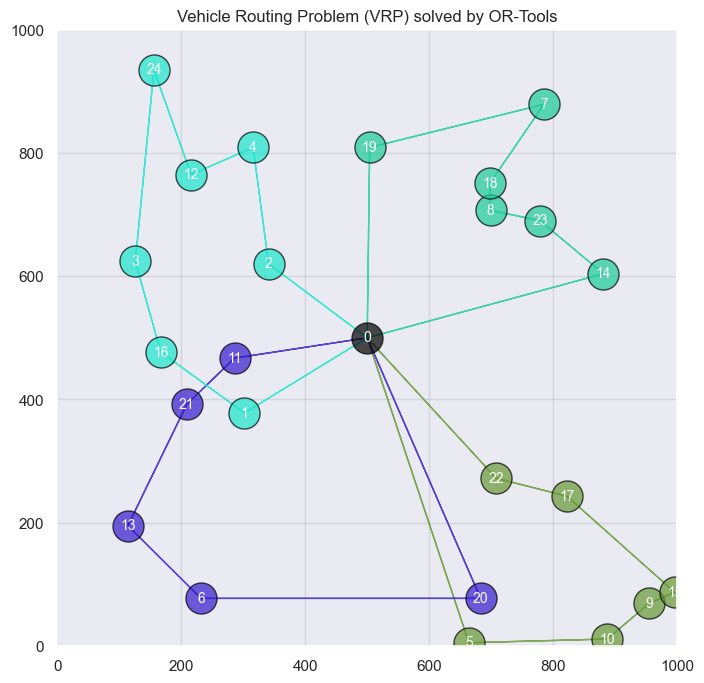

In [18]:
plot_map()